# MoCCA-SV benchmark notebook
The notebook is to carry on MoCCA-SV benchmark. The input files and options are all specified in the ["Configuration" cell](#Configuration).  The outputs of this benchmark are two CSV files, saved from pandas data frames, including the performance metrics, such as TP, FP, F1, etc.  The performance are subsetted by SV types.

---
## Initial setting

In [1]:
%cd /mnt/nfs/gigantor/ifs/DCEG/Projects/CoherentLogic/SV/mocca-bench
! module list

/mnt/nfs/gigantor/ifs/DCEG/Projects/CoherentLogic/SV/mocca-bench
Currently Loaded Modulefiles:
  1) tmux/2.5


---
## Configuration
The truth VCF file has been converted into the bed format, specified by ***TRUTH_BED***, whereas, the bed output from MoCCA-SV is named by ***COMP_BED***. The file ***INCLUDED_BED*** is to specified the regions to be included in the benchmark; it could be set to emtpy (i.e., ""), if it is not appliable. 

***calleres*** are those SV callers used in the MoCCA-SV pipelines, and the order is matched to their positions in the MoCCA-SV output bed file (*COMP_BED*).  By default, they are started from the 4th column in *COMP_BED*, which can be adjusted by the variable *first_caller_column*. 

***ensemble*** is to specified the ensemble prediction supported by any of one (or more) SV caller. The numeric list like "[10,12]" is to specify the caller position in the final combined bed file.  During the benchmark, we take the intersection between *TRUTH_BED* and *COMP_BED*.  The result bed file contains many columns: the first 6 are those from *TRUTH_BED* by default, and the remaining columns are those from *COMP_BED* in the order.  For instance, in this particular denomstration, "svaba" and "manta" are 1st and 3rd SV callers and located in 4th and 6th column in *COMP_BED*.  Their column positions are moved to 10th and 12th after the combination, which are specified as  ***svaba_or_manta":[10,12]*** as defined in *ensemble*. 

***OUTFN*** specifies the CSV file for the performance output, and ***SVTYPEFN*** specifies another CSV files for the benchmark performance segmented by SVTYPE and *SV_SIZE_BIN*. 

The remaining variables in the Configuration cell are more constant and are not likely to be modified between runs. 
+ TMP: Specifies the folder to keep temporary intermediate results.  It needs to be named differently if multiple benchmark are run simultaneously. 
+ N: Specifies the number of base pairs to be padded for each insertion
+ MIN_OVP: The minimum reciprocal overlap to be considered as a hit.
+ MAX_INS_GAP: This is an emperical cutoff.  We take intrachromosomal SVs with size less than MAX_INS_GAP as "insertion".
+ genome_file: Specifies the chromsome sizes of the reference genome, and to be used with bedtools slop. 
+ first_caller_column: First caller column position in *COMP_BED*, which is 1-based.
+ caller_cnt_column: There is one column "caller_cnt" in *COMP_BED*, which is right after all SV caller columns by default. 
+ SV_SIZE_BIN: Specifies the bin sizes of interest in python format, which is to be used in the table output saved in *SVTYPEFN*. 

In [2]:
### Setting for GIAB

# TRUTH_BED="data/my-tp-base.bed"
# COMP_BED="data/intrachromosomal_SVs_AJ_2x250_son"
# INCLUDED_BED="data/HG002_SVs_Tier1_noVDJorXorY_v0.6.2.bed" # Assign it to "", if there is not included be file
# callers = ['svaba', 'breakdancer', 'manta']
# ensemble={"svaba_or_manta":[10,12],
#           "svaba_or_breakdancer":[10,11],
#           "manta_or_breakdancer":[12,11],
#           "any_one":[10,11,12]
#           }
# OUTFN="GIAB_performance.csv"
# SVTYPEFN="GIAB_SVtype.csv"


## Setting for IS1
# svaba   breakdancer     delly   manta   gridss
TRUTH_BED="data/my_is1.bed" 
COMP_BED="../test/test_gridss_TN/output/compare_and_annotate/intrachromosomal_SVs_IS1"
INCLUDED_BED=""
columns=[10,11,12,13,14]
callers=["svaba", "breakerdancer", "delly", "manta", "gridss"]
OUTFN="IS1_performance.csv"
SVTYPEFN="IS1_SVtype.csv"
ensemble={"svaba_or_gridss":[10,14],
          "delly_or_gridss":[12,14],
          "manta_or_gridss":[13,14],
          "svaba_or_manta_or_gridss":[10,13,14]
         }

TMP="./TMP" #  temporary file is to be used for keep temporary intermediate results, will be overwrriten for each run
N=500 # for padding insertion
MIN_OVP=0.7 # for minimum reciprocal overlap
MAX_INS_GAP=20 # assume that breakpoint gap of the insert is no more than 20
genome_file = "./data/hg19_wo_chr.genome" 
TRUTH_BED_COLS=6 # the turth bed file contains 6 columns
first_caller_column= 4 # first caller position in MoCCA-SV; 1-based as to be used with awk
caller_cnt_column = len(callers) + 4 # caller_count column position; 1-based 

import numpy as np
SV_SIZE_BIN=[50, 100, 300, 1000, np.Inf]

In [3]:
### Several helper functions are defined here
%matplotlib inline

import os
import subprocess 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_shell(cmd, get_single_number=False, is_df=False):
    print("Run: "+cmd)
    try:
       grepOut = subprocess.check_output(cmd, shell=True, universal_newlines=True, stderr=subprocess.STDOUT)                       
    except subprocess.CalledProcessError as grepexc:                                                                                                   
        print("Error code", grepexc.returncode,'; ', grepexc.output)
    
    rv = None
    if get_single_number:
        rv=int(grepOut)
    else:
        rv=grepOut.rstrip().split("\n")
    
    if is_df:
        rv=pd.DataFrame([x.split('\t') for x in rv])
        
    return rv

def create_tmp_file(fn, tempdir=TMP, empty_file=False):
    tmp_fn = os.path.join(TMP, fn)
    
    if os.path.exists(tmp_fn):
        os.remove(tmp_fn)
    
    if empty_file:
        os.system("touch %s" % (tmp_fn))
    
    return(tmp_fn)
   
os.system("mkdir -p %s" % (TMP))

0

---
## Data process

### 1. Intersect with the included region if available

In the case of GIAB benchmark dataset, low complexity regions and complicated SV regions were excluded. Accordingly, we take only the truth SVs and predicted SVs within the included regions.

This step is optional is ***INCLUDED_BED*** is not defined or empty. 

In [4]:
truth_bed1=TRUTH_BED
comp_bed1=COMP_BED

if INCLUDED_BED is None or INCLUDED_BED=="":
    print("There is no included region specified!")
else:
    # print ("do something")
    truth_bed1 = create_tmp_file("truth_included.bed")
    comp_bed1 = create_tmp_file("comp_included.bed")
    cmd1="bedtools intersect -a %s -b %s -f 1.0000000 -u > %s" % (TRUTH_BED, INCLUDED_BED, truth_bed1)
    cmd2="bedtools intersect -a %s -b %s -f 1.0000000 -u > %s" % (COMP_BED, INCLUDED_BED, comp_bed1)
    _ = run_shell(cmd1)
    _ = run_shell(cmd2)
    

There is no included region specified!


### 1a. Cluster MoCCA-SV to have the unique ID
After excluding SV not within the regions specified by *INLCUDED_BED*, we cluster MoCCA-SV predictions and assign a unique ID. The column position of the unique ID is kept by the variable *cluster_last_col*.    

In [5]:
comp_cluster = os.path.join(TMP, "comp_cluster.bed")

_ = run_shell("bedtools cluster -i %s > %s" % (comp_bed1, comp_cluster))

cluster_last_col = run_shell("awk 'NR==1{print NF}' %s" %(comp_cluster), get_single_number=True)              
print("last column pos: ", cluster_last_col)  


Run: bedtools cluster -i ../test/test_gridss_TN/output/compare_and_annotate/intrachromosomal_SVs_IS1 > ./TMP/comp_cluster.bed
Run: awk 'NR==1{print NF}' ./TMP/comp_cluster.bed
last column pos:  29


### 2. Padding the insertions
In this step, each insertion are padded to extend 500 bp to each side. 

In [6]:
truth_bed2=create_tmp_file("truth_padded.bed")
comp_bed2=create_tmp_file("comp_padded.bed")

ins_bed=create_tmp_file("ins_padded.bed", empty_file=True)
oth_bed=create_tmp_file("others_padded.bed", empty_file=True)
cmd = "bedtools slop -g %s  -b %s "; 
    
pad_truth_cmd = """ 
 awk -v OFS='\\t' '{ 
    if($5 == "INS") 
        print $0 > "%s"; 
    else 
        print $0 > "%s";
    }' %s > /dev/null ; 
  cat %s >%s ; 
  bedtools slop -i %s -g %s  -b %s >> %s ;
""" % (ins_bed, oth_bed, truth_bed1, oth_bed, truth_bed2, ins_bed, genome_file, N, truth_bed2)
        
_= run_shell(pad_truth_cmd)

pad_comp_cmd = """ 
 awk -v OFS='\\t' '{ 
    if($3-$2 <= %d) 
        print $0 > "%s"; 
    else 
        print $0 > "%s";
    }' %s > /dev/null; 
  cat %s > %s;  
  bedtools slop -i %s -g %s  -b %s >> %s;
""" % (MAX_INS_GAP, ins_bed, oth_bed, comp_bed1, oth_bed, comp_bed2, ins_bed, genome_file, N, comp_bed2)
        
_= run_shell(pad_comp_cmd)


# pad_comp_cmd = """ 
#  awk -v OFS='\\t' '{ 
#     cmd = "bedtools slop -g %s  -b %d "; 
#     if($3-$2 <= %d) 
#         print $0 | cmd; 
#     else 
#         print $0 
#     }' %s > %s 
# """ % (genome_file, N, MAX_INS_GAP, comp_bed1, comp_bed2)
        
# _= run_shell(pad_comp_cmd)


Run:  
 awk -v OFS='\t' '{ 
    if($5 == "INS") 
        print $0 > "./TMP/ins_padded.bed"; 
    else 
        print $0 > "./TMP/others_padded.bed";
    }' data/my_is1.bed > /dev/null ; 
  cat ./TMP/others_padded.bed >./TMP/truth_padded.bed ; 
  bedtools slop -i ./TMP/ins_padded.bed -g ./data/hg19_wo_chr.genome  -b 500 >> ./TMP/truth_padded.bed ;

Run:  
 awk -v OFS='\t' '{ 
    if($3-$2 <= 20) 
        print $0 > "./TMP/ins_padded.bed"; 
    else 
        print $0 > "./TMP/others_padded.bed";
    }' ../test/test_gridss_TN/output/compare_and_annotate/intrachromosomal_SVs_IS1 > /dev/null; 
  cat ./TMP/others_padded.bed > ./TMP/comp_padded.bed;  
  bedtools slop -i ./TMP/ins_padded.bed -g ./data/hg19_wo_chr.genome  -b 500 >> ./TMP/comp_padded.bed;



### 3. Get the intersections between the truth bed and the compute bed 
The processed TRUTH_BED and COMP_BED are intersected using bedtools. The intrachromosomal SVs predicted by MoCCA-SV with at least ***MIN_OVP*** reciprocal overap with the truth bed file are considered as TP.  

We repeat the intersection three times here to capture different information.
+ isec_bed: keep columns/information from both the truth bed and compute bed files of TPs.
+ isec_truth_bed: keep only columns from the truth bed of those TPs.
+ isec_fp_bed: keep only columns from ***COMP_BED***, which are not matched with any ***TRUTH_BED***, i.e., those are FPs. 

In [7]:
isec_bed = create_tmp_file("isec.bed")

isec_cmd = """
             bedtools intersect -a %s -b %s -wa -wb -f %f -r > %s
           """ % (truth_bed2, comp_bed2, MIN_OVP, isec_bed)
_=run_shell(isec_cmd)

isec_truth_bed = create_tmp_file("isec_truth.bed")
isec_truth_cmd = """
             bedtools intersect -a %s -b %s -u -f %f -r > %s
           """ % (truth_bed2, comp_bed2, MIN_OVP, isec_truth_bed)
_=run_shell(isec_truth_cmd)


### Repeat the similar command but to keep fp from MoCCA
isec_fp_bed = create_tmp_file("isec_fp.bed")

isec_fp_cmd = """
             bedtools intersect -a %s -b %s -v -f %f -r > %s
           """ % (comp_bed2, truth_bed2, MIN_OVP, isec_fp_bed)
_=run_shell(isec_fp_cmd)



Run: 
             bedtools intersect -a ./TMP/truth_padded.bed -b ./TMP/comp_padded.bed -wa -wb -f 0.700000 -r > ./TMP/isec.bed
           
Run: 
             bedtools intersect -a ./TMP/truth_padded.bed -b ./TMP/comp_padded.bed -u -f 0.700000 -r > ./TMP/isec_truth.bed
           
Run: 
             bedtools intersect -a ./TMP/comp_padded.bed -b ./TMP/truth_padded.bed -v -f 0.700000 -r > ./TMP/isec_fp.bed
           


### 4. Summary the results
#### 4.1. Collect counts of SV predictions, and true positives
+ ***tps*** is the python list to keep true positives, based on ***isec_bed***.  
+ ***all_callers*** is a list to keep the name of callers (including the ensemble callers).
+ ***preds*** is to keep the count of SV predictions from the processed ***COMP_BED***
+ ***svtype*** is a python DataFrame to keep  SV type and interval size of the true positives

In [8]:
### Counter the numbers of the true predictions (tps) and the all predictions (preds) 

tps=[] # Count 
all_callers=[]
preds=[]

# svtype is to keep a record of SV types and Lengths 
svtype=pd.DataFrame(columns=['Caller', 'SVtype', "SVlen"])

svtype_truth=None
for i,caller in enumerate(callers):
    tp_cmd = """
            awk  '{if($%d=="orig") print $4}' %s | sort -u |wc -l
        """ % (i + first_caller_column + TRUTH_BED_COLS, isec_bed)
    tps.append(run_shell(tp_cmd, get_single_number=True))
    
    pred_cmd = """
            awk  '{if($%d=="orig") print}' %s | wc -l
        """ % (i + first_caller_column, comp_bed1)
    preds.append(run_shell(pred_cmd, get_single_number=True))
    
    
    tp_svtype_cmd = """
            awk  '$%d=="orig"' %s | awk -v OFS='\t' '{if(!seen[$4]++) print $5,$6}' 
        """ % (i + first_caller_column + TRUTH_BED_COLS, isec_bed)
    tp_svtype=run_shell(tp_svtype_cmd, is_df=True)
    
    svtype=svtype.append(pd.DataFrame({"Caller":caller, "SVtype":tp_svtype.iloc[:,0], "SVlen":tp_svtype.iloc[:,1]}))
    
    
    all_callers.append(caller)

print(all_callers)
print(preds)
print(tps)


Run: 
            awk  '{if($10=="orig") print $4}' ./TMP/isec.bed | sort -u |wc -l
        
Run: 
            awk  '{if($4=="orig") print}' ../test/test_gridss_TN/output/compare_and_annotate/intrachromosomal_SVs_IS1 | wc -l
        
Run: 
            awk  '$10=="orig"' ./TMP/isec.bed | awk -v OFS='	' '{if(!seen[$4]++) print $5,$6}' 
        
Run: 
            awk  '{if($11=="orig") print $4}' ./TMP/isec.bed | sort -u |wc -l
        
Run: 
            awk  '{if($5=="orig") print}' ../test/test_gridss_TN/output/compare_and_annotate/intrachromosomal_SVs_IS1 | wc -l
        
Run: 
            awk  '$11=="orig"' ./TMP/isec.bed | awk -v OFS='	' '{if(!seen[$4]++) print $5,$6}' 
        
Run: 
            awk  '{if($12=="orig") print $4}' ./TMP/isec.bed | sort -u |wc -l
        
Run: 
            awk  '{if($6=="orig") print}' ../test/test_gridss_TN/output/compare_and_annotate/intrachromosomal_SVs_IS1 | wc -l
        
Run: 
            awk  '$12=="orig"' ./TMP/isec.bed | awk -v OFS='	' '{if(!s

In [9]:
print(all_callers)
print(preds)
print(tps)
print(caller)
print(tp_svtype_cmd)

['svaba', 'breakerdancer', 'delly', 'manta', 'gridss']
[390, 93411, 860, 331, 298]
[304, 124, 260, 315, 298]
gridss

            awk  '$14=="orig"' ./TMP/isec.bed | awk -v OFS='	' '{if(!seen[$4]++) print $5,$6}' 
        


#### 4.2. Continue to collect counts for the ensemble caller defined by the variable ***ensemble***

In [10]:
# work on the ensemble call 
# get prediction count using bedtools cluster


for k in ensemble.keys():
    print(k)
    
    tp_tmp_file=create_tmp_file("%s_tp.tmp" % k, empty_file=True)
    pred_tmp_file=create_tmp_file( "%s_pred.tmp" % k, empty_file=True)
    

    for i in ensemble[k]:
        # count tp from the intersection
        cmd= """
                awk   '$%d=="orig"' %s >> %s
             """ % (i, isec_bed, tp_tmp_file)
        _=run_shell(cmd)
        
        # count pred from the clustered MoCCA-SV
#         cmd2="""
#                 awk   '$%d=="orig"' %s >> %s
#              """ % (i-TRUTH_BED_COLS, comp_cluster, pred_tmp_file)
#         _=run_shell(cmd2)
        
        # count fp from isec_fp_bed and cluster again as the count of fp
        cmd2="""
                awk  '$%d=="orig"' %s >> %s
             """ % (i-TRUTH_BED_COLS, isec_fp_bed, pred_tmp_file)
        _=run_shell(cmd2)
    
        
    tp=run_shell("cut -f 4 %s | sort -u |wc -l" % (tp_tmp_file), get_single_number=True)
    # pred=run_shell("cut -f %d %s | sort -u  |wc -l" % (cluster_last_col, pred_tmp_file), get_single_number=True)
    # get the count of prediction in the othe way: Count the number of FP
    # I may need to remove comp_cluster file as it is not of use any more
    fp = run_shell("""
             bedtools cluster -i %s | cut -f %d | sort -u |wc -l  
           """ % (pred_tmp_file, cluster_last_col),  get_single_number=True)
    pred = tp + fp
    print(tp)
    print(pred)
    
    # get svtype from tp_tmp_bed
    tp_svtype_cmd = """
                    cat %s | awk -v OFS='\t'  '{if(!seen[$4]++) print $5,$6}' 
                """ % (tp_tmp_file)
    tp_svtype=run_shell(tp_svtype_cmd,is_df=True)

    svtype=svtype.append(pd.DataFrame({"Caller":k, "SVtype":tp_svtype.iloc[:,0], "SVlen":tp_svtype.iloc[:,1]}))
    
    all_callers.append(k)
    tps.append(tp)
    preds.append(pred)



svaba_or_gridss
Run: 
                awk   '$10=="orig"' ./TMP/isec.bed >> ./TMP/svaba_or_gridss_tp.tmp
             
Run: 
                awk  '$4=="orig"' ./TMP/isec_fp.bed >> ./TMP/svaba_or_gridss_pred.tmp
             
Run: 
                awk   '$14=="orig"' ./TMP/isec.bed >> ./TMP/svaba_or_gridss_tp.tmp
             
Run: 
                awk  '$8=="orig"' ./TMP/isec_fp.bed >> ./TMP/svaba_or_gridss_pred.tmp
             
Run: cut -f 4 ./TMP/svaba_or_gridss_tp.tmp | sort -u |wc -l
Run: 
             bedtools cluster -i ./TMP/svaba_or_gridss_pred.tmp | cut -f 29 | sort -u |wc -l  
           
310
328
Run: 
                    cat ./TMP/svaba_or_gridss_tp.tmp | awk -v OFS='	'  '{if(!seen[$4]++) print $5,$6}' 
                
delly_or_gridss
Run: 
                awk   '$12=="orig"' ./TMP/isec.bed >> ./TMP/delly_or_gridss_tp.tmp
             
Run: 
                awk  '$6=="orig"' ./TMP/isec_fp.bed >> ./TMP/delly_or_gridss_pred.tmp
             
Run: 
                awk   '$14=

#### 4.3. Continue to collect counts for the MoCCA-SV build-in ensemble caller.

In the MoCCA-SV bed file outptu, there is a column "caller_cnt" defined in the position ***caller_cnt_column***. Accordingly, we may select ensemble SV predictions supported by one or more SV callers: e.g., any_1, any_2, and any_3.  

In [11]:
# use the ensemble call built in MoCCAV, that is, caller_cnt_column (+ TRUTH_BED_COLS for intersect file)

for i,_ in enumerate(callers, 1):
    caller="any_%d" % i
    print(caller)
    
    tp_cmd = """
            awk  '{if($%d>=%d) print $4}' %s | sort -u |wc -l
        """ % (caller_cnt_column + TRUTH_BED_COLS, i, isec_bed)
    tp = run_shell(tp_cmd, get_single_number=True)
    tps.append(tp)
    
    fp_cmd = """
            awk  '{if($%d>=%d) print $0}' %s | bedtools cluster | cut -f %d| sort -u | wc -l
        """ % (caller_cnt_column, i, isec_fp_bed, cluster_last_col)
    
    fp = run_shell(fp_cmd, get_single_number=True)
    pred = tp + fp
    preds.append(pred)
    
    
    tp_svtype_cmd = """
            awk  '$%d>=%d' %s | awk -v OFS='\t' '{if(!seen[$4]++) print $5,$6}' 
        """ % (caller_cnt_column + TRUTH_BED_COLS, i, isec_bed)
    
    tp_svtype=run_shell(tp_svtype_cmd,is_df=True)

    svtype=svtype.append(pd.DataFrame({"Caller":caller, "SVtype":tp_svtype.iloc[:,0], "SVlen":tp_svtype.iloc[:,1]}))
    
    
    
    all_callers.append(caller)

    
    

any_1
Run: 
            awk  '{if($15>=1) print $4}' ./TMP/isec.bed | sort -u |wc -l
        
Run: 
            awk  '{if($9>=1) print $0}' ./TMP/isec_fp.bed | bedtools cluster | cut -f 29| sort -u | wc -l
        
Run: 
            awk  '$15>=1' ./TMP/isec.bed | awk -v OFS='	' '{if(!seen[$4]++) print $5,$6}' 
        
any_2
Run: 
            awk  '{if($15>=2) print $4}' ./TMP/isec.bed | sort -u |wc -l
        
Run: 
            awk  '{if($9>=2) print $0}' ./TMP/isec_fp.bed | bedtools cluster | cut -f 29| sort -u | wc -l
        
Run: 
            awk  '$15>=2' ./TMP/isec.bed | awk -v OFS='	' '{if(!seen[$4]++) print $5,$6}' 
        
any_3
Run: 
            awk  '{if($15>=3) print $4}' ./TMP/isec.bed | sort -u |wc -l
        
Run: 
            awk  '{if($9>=3) print $0}' ./TMP/isec_fp.bed | bedtools cluster | cut -f 29| sort -u | wc -l
        
Run: 
            awk  '$15>=3' ./TMP/isec.bed | awk -v OFS='	' '{if(!seen[$4]++) print $5,$6}' 
        
any_4
Run: 
            awk  '{if($15

#### 4.4. Summerizee the performance of SV callers

In [12]:
# Collect SVtype and SVlength from the truth bed file
truth_df=pd.read_csv(TRUTH_BED, sep="\t", names=["chrom", "start", "end", "name", "svtype", "svlen"])

truth_df.head()
svtype=svtype.append(pd.DataFrame({"Caller":"Truth", "SVtype":truth_df["svtype"], "SVlen":truth_df["svlen"]}))

svtype = svtype.assign(SVlen=lambda df:df.SVlen.astype(int))
sv_cnt = svtype.groupby(['Caller', 'SVtype', pd.cut(svtype.SVlen, SV_SIZE_BIN, right=False)]).size()

In [13]:
sv_cnt.unstack(0)

Caller                  Truth  any_1  any_2  any_3  any_4  any_5  \
SVtype SVlen                                                       
DEL    [50.0, 100.0)        0      0      0      0      0      0   
       [100.0, 300.0)       0      0      0      0      0      0   
       [300.0, 1000.0)      2      2      2      1      1      1   
       [1000.0, inf)      118    101     98     95     75     29   
DUP    [50.0, 100.0)        0      0      0      0      0      0   
       [100.0, 300.0)       0      0      0      0      0      0   
       [300.0, 1000.0)      1      1      1      1      1      0   
       [1000.0, inf)      123    104    103    102     98      7   
INV    [50.0, 100.0)        0      0      0      0      0      0   
       [100.0, 300.0)       0      0      0      0      0      0   
       [300.0, 1000.0)      0      0      0      0      0      0   
       [1000.0, inf)      127    118    111    109    106     34   

Caller                  breakerdancer  delly  delly_or_gridss  gridss  manta  \
SVtype SVlen                                                                   
DEL    [50.0, 100.0)                0      0                0       0      0   
       [100.0, 300.0)               0      0                0       0      0   
       [300.0, 1000.0)              1      2                2       1      1   
       [1000.0, inf)               64     49               92      90     99   
DUP    [50.0, 100.0)                0      0                0       0      0   
       [100.0, 300.0)               0      0                0       0      0   
       [300.0, 1000.0)              0      1                1       1      1   
       [1000.0, inf)               10    100              104     101    103   
INV    [50.0, 100.0)                0      0                0       0      0   
       [100.0, 300.0)               0      0                0       0      0   
       [300.0, 1000.0)              0      0                0       0      0   
       [1000.0, inf)               49    108              109     105    111   

Caller                  manta_or_gridss  svaba  svaba_or_gridss  \
SVtype SVlen                                                      
DEL    [50.0, 100.0)                  0      0                0   
       [100.0, 300.0)                 0      0                0   
       [300.0, 1000.0)                1      2                2   
       [1000.0, inf)                 99     96               96   
DUP    [50.0, 100.0)                  0      0                0   
       [100.0, 300.0)                 0      0                0   
       [300.0, 1000.0)                1      1                1   
       [1000.0, inf)                104    100              104   
INV    [50.0, 100.0)                  0      0                0   
       [100.0, 300.0)                 0      0                0   
       [300.0, 1000.0)                0      0                0   
       [1000.0, inf)                111    105              107   

Caller                  svaba_or_manta_or_gridss  
SVtype SVlen                                      
DEL    [50.0, 100.0)                           0  
       [100.0, 300.0)                          0  
       [300.0, 1000.0)                         2  
       [1000.0, inf)                          99  
DUP    [50.0, 100.0)                           0  
       [100.0, 300.0)                          0  
       [300.0, 1000.0)                         1  
       [1000.0, inf)                         104  
INV    [50.0, 100.0)                           0  
       [100.0, 300.0)                          0  
       [300.0, 1000.0)                         0  
       [1000.0, inf)                         111

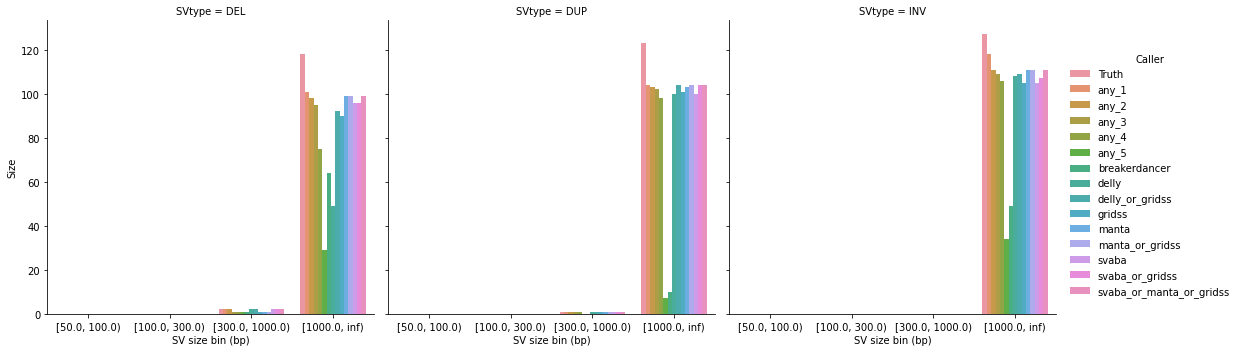

In [14]:

data=sv_cnt.reset_index(name="Size")
data.head()

fg = sns.catplot(x='SVlen', y='Size', hue='Caller', 
                        col='SVtype', data=data, kind='bar')
fg.set_xlabels('SV size bin (bp)')


In [15]:
truth_cnt = run_shell("cat %s | wc -l" % (TRUTH_BED), get_single_number=True)
df = pd.DataFrame({"Truth":truth_cnt, 
                   "PRED":preds,
                   "TP":tps
                  }, index=all_callers).assign(
                        FP=lambda df:df.PRED-df.TP,
                        FN=lambda df:df.Truth-df.TP, 
                        Sp=lambda df: df.TP/df.PRED, 
                        Sn=lambda df: df.TP/df.Truth,
                        F1=lambda df:2*df.TP/(2*df.TP+df.FP+df.FN)
                  )

df.index.name="Caller" 
df

Run: cat data/my_is1.bed | wc -l


,Truth,PRED,TP,FP,FN,Sp,Sn,F1
Caller,,,,,,,,
svaba,371,390,304,86,67,0.779487,0.819407,0.798949
breakerdancer,371,93411,124,93287,247,0.001327,0.334232,0.002644
delly,371,860,260,600,111,0.302326,0.700809,0.422421
manta,371,331,315,16,56,0.951662,0.849057,0.897436
gridss,371,298,298,0,73,1.000000,0.803235,0.890882
svaba_or_gridss,371,328,310,18,61,0.945122,0.835580,0.886981
delly_or_gridss,371,743,308,435,63,0.414536,0.830189,0.552962
manta_or_gridss,371,323,316,7,55,0.978328,0.851752,0.910663
svaba_or_manta_or_gridss,371,342,317,25,54,0.926901,0.854447,0.889201


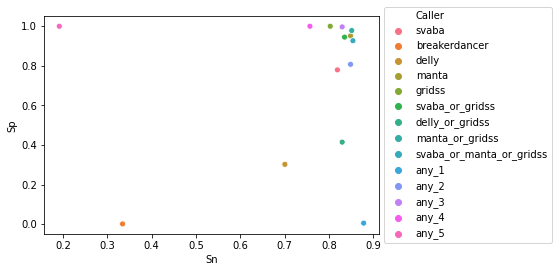

In [16]:

df.index.name="Caller"
dat = df.reset_index()
dat.head()
g=sns.scatterplot(x="Sn", y="Sp", data=dat,hue="Caller")
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.show()

#### 4.5. Save the two tables into CSV files.

In [17]:
# Save to files
df.to_csv(OUTFN)
sv_cnt.unstack(0).to_csv(SVTYPEFN)